# CMSC320 Project 3: Gapminder
# Part 1: Regression analysis of Gapminder data
Read in the data.

In [4]:
import pandas as pd
gap_data = pd.read_csv("mirror/08_gap-every-five-years.tsv", sep='\t')
gap_data.head()

,country,continent,year,lifeExp,pop,gdpPercap
0,Afghanistan,Asia,1952,28.801,8425333,779.445314
1,Afghanistan,Asia,1957,30.332,9240934,820.853030
2,Afghanistan,Asia,1962,31.997,10267083,853.100710
3,Afghanistan,Asia,1967,34.020,11537966,836.197138
4,Afghanistan,Asia,1972,36.088,13079460,739.981106


## Exericise 1: Plot Life Expectancy Across Time

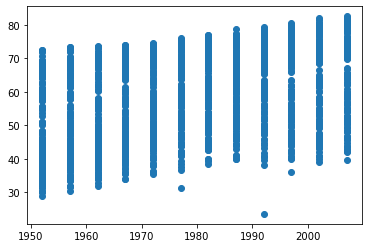

In [9]:
import matplotlib.pyplot as plt
plt.scatter(gap_data['year'], gap_data['lifeExp'])
plt.show()

## Question 1
The average life expectancy appears to be increasing over time. This trend also does appear to be linear. However, the distributions of life expectancies across countries for each year are quite spread out.

Look at violin plot:

Partition data by year.

In [15]:
years = pd.unique(gap_data['year'])
life_exp_per_year = []
for year in years:
    sub = gap_data[gap_data['year'] == year]
    life_exp_per_year.append(sub['lifeExp'])

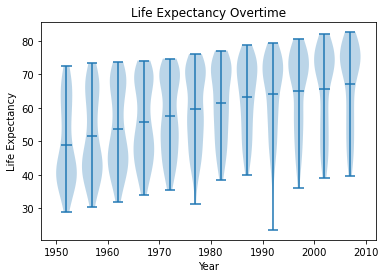

In [17]:
fig, ax = plt.subplots()

ax.violinplot(life_exp_per_year,years,widths=4,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("Life Expectancy")
ax.set_title("Life Expectancy Overtime")
plt.show()

In [241]:
years

array([1952, 1957, 1962, 1967, 1972, 1977, 1982, 1987, 1992, 1997, 2002,
       2007])

## Question 2
The distributions of life expectancies across countries for each year appear to be more right-skewed for years before 1977, and more left-skewed for years 1977 and onwards. The distributions for the years 1962-72 appear somewhat bimodal. None of the distributions appear very symmetric.

## Question 3
I would reject the null hypothesis of no relationship because the average life expectancy does appear to be increasing overtime.

## Question 4
A violin plot of residuals would most likely display skewed distributions for each year because the original violin plot displayed skewed distributions, so the distribution of distances from the prediction would also likely be skewed.

## Question 5
The linear regression model assumes that the data points are from independent, identical distributions and that the residuals follow a Gaussian distribution with a mean of zero.

## Exercise 2

In [20]:
import numpy as np
model = np.polyfit(gap_data['year'], gap_data['lifeExp'], 1)
reg_coef = np.poly1d(model)
reg_coef

poly1d([ 3.25903828e-01, -5.85652187e+02])

### Life Expectancy = 0.326*(year) - 585.65

In [250]:
import statsmodels.formula.api as smf

res = smf.ols(formula='lifeExp ~ year', data=gap_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                lifeExp   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     398.6
Date:                Tue, 29 Nov 2022   Prob (F-statistic):           7.55e-80
Time:                        22:37:35   Log-Likelihood:                -6597.9
No. Observations:                1704   AIC:                         1.320e+04
Df Residuals:                    1702   BIC:                         1.321e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -585.6522     32.314    -18.124      0.0

## Question 6
On average, the global life expectancy is expected to increase by about 0.326 years each year

## Question 7

Look at r (correlation coefficient).

In [26]:
from sklearn.metrics import r2_score
import math
R2 = r2_score(gap_data['lifeExp'], reg_coef(gap_data['year']))
math.sqrt(R2)

0.4356112240540734

With a correlation coefficient of 0.4356, the strength of the correlation is moderate, so we can reject the null hypothesis.

## Exercise 3

Calculate the residuals for each year.

In [ ]:
for index in range(len(life_exp_per_year)):
    pred = reg_coef(years[index])
    life_exp_per_year[index] -= pred

Make violin plot of residuals for each year.

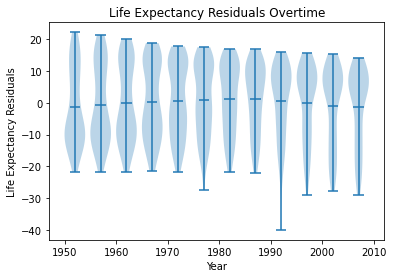

In [37]:
fig, ax = plt.subplots()

ax.violinplot(life_exp_per_year,years,widths=4,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("Life Expectancy Residuals")
ax.set_title("Life Expectancy Residuals Overtime")
plt.show()

## Question 8

The violin plot of residuals did meet my expectations, in that most of the distributions of residuals for each year appear skewed because the original distributions of the life expectancies for each year were also skewed.

## Exercise 4

Add residuals column to the data.

In [48]:
residuals = []
for index in range(len(life_exp_per_year)):
    residuals += list(life_exp_per_year[index])
gap_data['residuals'] = residuals
gap_data.head()

,country,continent,year,lifeExp,pop,gdpPercap,residuals
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,-21.711084
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,4.717916
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,-7.435084
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,-20.497084
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,11.972916


Boxplot of model residuals vs continent.

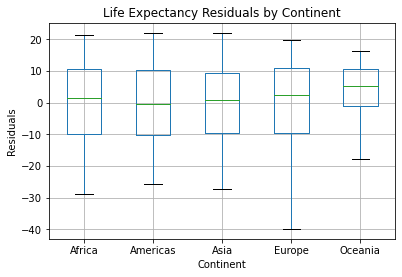

In [52]:
gap_data.boxplot(column='residuals', by='continent')
plt.suptitle('')
plt.title('Life Expectancy Residuals by Continent')
plt.xlabel('Continent')
plt.ylabel('Residuals')
plt.show()

## Question 9

The residuals appear to be mostly centered around zero for every continent except Oceania, which has higher residuals on average. It may be necessary to first partition by continent and then conduct a separate regression analysis for each continent because there seems to be a dependence between residuals and continent. Specifically, the continent also influences the life expectancy in addition to the year. This may be because certain continents are on average wealthier than others and as a result have less crime and better access to healthcare, nutrition, and education which influences their life expectancy.

## Exercise 5

Scatter plot with regression line for each continent.

Africa:  
0.2895 x - 524.3
Americas:  
0.3677 x - 663.1
Asia:  
0.4531 x - 836.9
Europe:  
0.2219 x - 367.4
Oceania:  
0.2103 x - 341.9


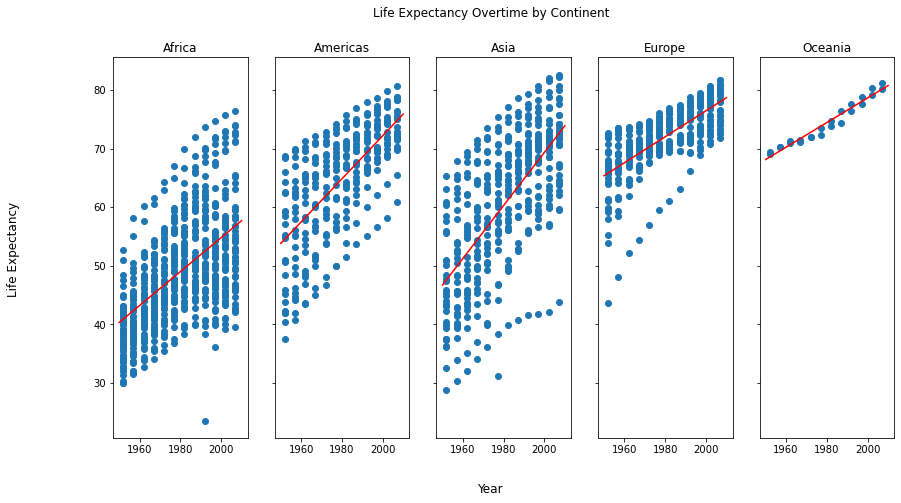

In [240]:
fig, axs = plt.subplots(1, 5, figsize=(14, 7), sharey=True)

fig.suptitle('Life Expectancy Overtime by Continent')
fig.supxlabel('Year')
fig.supylabel('Life Expectancy')

index = 0

for continent in ['Africa','Americas','Asia','Europe','Oceania']:
    sub_df = gap_data[gap_data['continent'] == continent]
    axs[index].scatter(sub_df['year'], sub_df['lifeExp'])
    axs[index].set_title(continent)
    z = np.polyfit(sub_df['year'], sub_df['lifeExp'], 1)
    p = np.poly1d(z)
    print(continent + ': ' + str(p))
    xp = np.linspace(1950, 2010, 100)
    axs[index].plot(xp, p(xp), color='red')
    index += 1

plt.show()

## Question 10

The regression model should include an interaction term for continent and year because the slopes and intercepts of the regression lines appear to be significantly different for each continent. There is a clear relationship between each continent and the life expectancy, because the variance in life expectancy cannot be explained by just the year. Thus, from the previous plot, the variance in life expectancy can be further explained by the inclusion of continent as well.

## Exercise 6

Assuming that the life expectancies for each continent follow a Gaussian distribution, fit a GLM to the data with interactions between continents and year.

In [68]:
import statsmodels.formula.api as smf

res1 = smf.glm(formula='lifeExp ~ continent + year + continent*year', data=gap_data[['continent','year','lifeExp']]).fit()

print(res1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                lifeExp   No. Observations:                 1704
Model:                            GLM   Df Residuals:                     1694
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                          51.547
Method:                          IRLS   Log-Likelihood:                -5771.9
Date:                Thu, 24 Nov 2022   Deviance:                       87320.
Time:                        15:42:17   Pearson chi2:                 8.73e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8936
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

## Question 11

The parameters in the model are all significantly different from zero, except for Oceania and the interaction between Oceania and year because these two parameters have high p-values (using a threshold of alpha = 0.05). The parameters for Africa were not shown because the model uses Africa as the baseline (as seen from the 9 degrees of freedom when the model has 10 variables/interactions).

## Question 12

On average, life expectancy is expected to increase each year by 0.29 years for Africa, (0.29 + 0.08 = 0.37) years for the Americas, (0.29 + 0.16 = 0.45) years for Asia, (0.29 - 0.07 = 0.22) years for Europe and (0.29 - 0.08 = 0.21) years for Oceania. However, the prediction for Oceania may not be very accurate because of the high p-values associated with its coefficients.

## Exercise 7

Add response residuals column to the data.

In [75]:
gap_data['glm_residuals'] = res1.resid_response
gap_data.head()

,country,continent,year,lifeExp,pop,gdpPercap,residuals,glm_residuals
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,-21.711084,-18.803037
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,4.717916,-19.537649
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,-7.435084,-20.138261
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,-20.497084,-20.380873
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,11.972916,-20.578485


Create new vector with separate vectors for each year.

In [85]:
glm_res = []
for year in years:
    sub = gap_data[gap_data['year'] == year]
    glm_res.append(sub['glm_residuals'])

Create a violin plot of GLM residuals for each year.

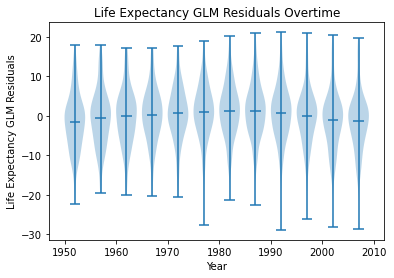

In [89]:
fig, ax = plt.subplots()

ax.violinplot(glm_res,years,widths=4,showmeans=True)
ax.set_xlabel("Year")
ax.set_ylabel("Life Expectancy GLM Residuals")
ax.set_title("Life Expectancy GLM Residuals Overtime")
plt.show()

The generalized linear model assumed that the life expectancies for each continent in each year would be normally distributed. Here, the residuals for all of the continents for each year do appear to mostly follow a normal distribution.

# Part 2: Classification

I have chosen to use a dataset of Pokemon attributes, with information about each Pokemon's combat values (attack, defense, speed, etc.). I will use these attributes to try and predict a Pokemon's primary type. The two models that I will try are decision trees and k nearest neighbors. We will use 6 features to build our models: HP (hit points), Attack, Defense, Sp. Attack, Sp. Defense, and Speed. To keep things simple, we will only try to predict a Pokemon's first type for those that have two types. We will randomly split the data into an 80 percent training set and a 20 percent test set (hold-out validation).

The dataset can be found here: https://www.kaggle.com/datasets/abcsds/pokemon?resource=download


Load the data in.

In [90]:
pokemon_df = pd.read_csv('~/Downloads/Pokemon.csv')
pokemon_df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


## Data Cleaning

Get rid of columns we don't care about (number, generation, legendary).

In [156]:
pokemon_df2 = pokemon_df.drop(['#', 'Generation', 'Legendary'], axis=1)
pokemon_df2.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80
4,Charmander,Fire,NaN,309,39,52,43,60,50,65


Remove mega versions of pokemon because we do not want duplicates and want to look at a Pokemon's base attributes rather than a stronger version.

In [157]:
mega = pokemon_df2.index[pokemon_df2['Name'].str.contains('Mega')].tolist() # get indices of mega pokemon
pokemon_df3 = pokemon_df2.drop(index=mega)
pokemon_df3.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80
4,Charmander,Fire,NaN,309,39,52,43,60,50,65
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80


In [158]:
pokemon_df3.shape

(751, 10)

We will now analyze these 751 Pokemon.

## EDA

Which types of Pokemon are there?

In [159]:
pd.unique(pokemon_df3['Type 1'])

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

There are 18 unique types of Pokemon in the dataset.

How many pokemon of each type are there?

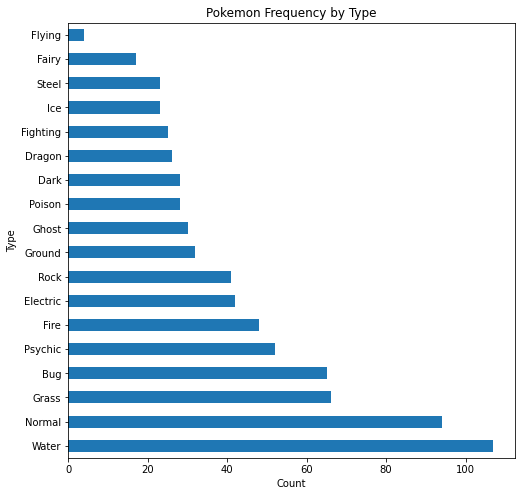

In [160]:
counts = pd.value_counts(pokemon_df3['Type 1'])
plt.figure(figsize=(8,8))
counts.plot.barh()
plt.title('Pokemon Frequency by Type')
plt.xlabel('Count')
plt.ylabel('Type')
plt.show()

Water and normal appear to be the most common types. Classification may not be as good for some of the less common types in the dataset (i.e. Fairy, Flying).

## Classification Method 1: Decision Tree

Filter the data into numerical and target values.

In [163]:
stats = pokemon_df3.iloc[:, 4:]
target = pokemon_df3['Type 1']

Split the data into a training and testing set.

In [164]:
from sklearn.model_selection import train_test_split

stats_train, stats_test, target_train, target_test = train_test_split(stats, target, test_size=0.2, random_state=42)

Let's look at the training set:

In [171]:
stats_train.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
143,48,48,48,48,48,48
50,75,80,85,110,90,50
77,80,105,65,100,70,70
721,40,45,40,62,60,60
226,90,120,75,60,60,45


In [172]:
target_train.head()

143    Normal
50      Grass
77      Grass
721      Fire
226     Fairy
Name: Type 1, dtype: object

In [165]:
stats_train.shape

(600, 6)

In [166]:
stats_test.shape

(151, 6)

So the training set has 600 pokemon and the testing set has 151. Let's make sure that the training set has pokemon of every type so that it is possible for every type to be predicted.

In [170]:
pd.unique(target_train)

array(['Normal', 'Grass', 'Fire', 'Fairy', 'Rock', 'Dragon', 'Ghost',
       'Poison', 'Water', 'Psychic', 'Steel', 'Ground', 'Electric',
       'Fighting', 'Dark', 'Bug', 'Ice', 'Flying'], dtype=object)

All 18 types are included in the training set.

## Model Training

I have chosen to use the default hyper-parameters provided by DecisionTreeClassifier because trying different parameters such as using "random" instead of "best" split and reducing the max_depth resulted in lower accuracy scores for the testing set. I also chose the arbitrary random_state of 42 in order to get consistent, reproducible results.

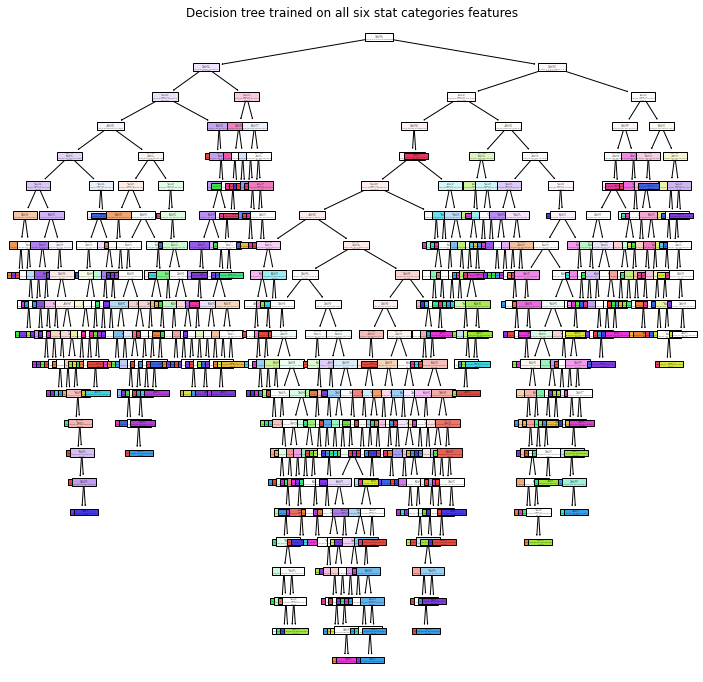

In [225]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

plt.figure(figsize=(12,12))
clf = DecisionTreeClassifier(random_state=42).fit(stats_train, target_train)
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all six stat categories features")
plt.show()

## Model Evaluation

We will use the accuracy metric to evaluate the performance of the model (i.e. percent of predictions that are correct).

Accuracy of tree for training set:

In [226]:
clf.score(stats_train, target_train)

0.9883333333333333

The prediction accuracy for the training set is very high, indicating that over-fitting may have occurred.

Accuracy of tree for testing set:

In [227]:
clf.score(stats_test, target_test)

0.16556291390728478

The model is only 16.56 percent accurate for the testing set. Note this is better than random guessing (1/18 = 0.056).

Let's look at the first 5 predictions made by the model for the testing set:

In [228]:
clf.predict(stats_test)[0:5]

array(['Psychic', 'Ice', 'Fairy', 'Electric', 'Poison'], dtype=object)

Versus the actual types:

In [176]:
target_test.head()

519     Fairy
392      Dark
145     Water
272     Grass
325    Normal
Name: Type 1, dtype: object

We have seen that using a DecisionTreeClassifier does not produce very accurate predictions. Let us now try a different approach.

## Classification Method 2: kNN Classification

The decision tree may not have been that effective because it was forced to rank the features based on importance when all the features may be equally important in determining a Pokemon's primary type. We will now try using the k nearest neighbors algorithm instead. To compare the performances of these two models, we will use the same training and test set as the previous method.

To choose a value for k (number of neighbors), let's experiment with various values of k and observe how accurate the model's predictions are on the testing and training sets.

Create lists of accuracy scores ranging from k=1 to k= 30 for the training and testing sets.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

train_scores = []
test_scores = []
for k in range(30):
    knn = KNeighborsClassifier(n_neighbors = k+1)
    knn.fit(stats_train, target_train)
    train_scores.append(knn.score(stats_train, target_train))
    test_scores.append(knn.score(stats_test, target_test))

Plot these values:

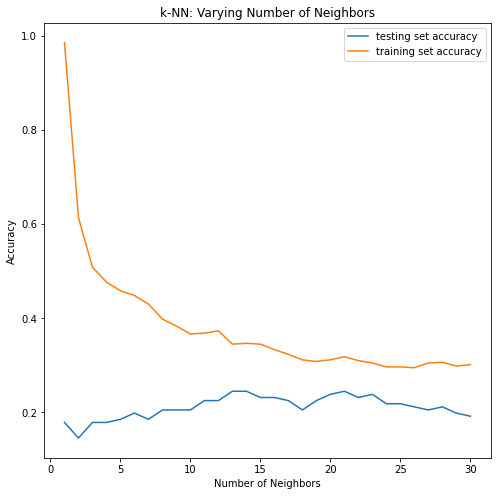

In [203]:
num_neighbors = np.arange(1,31)
plt.figure(figsize=(8,8))
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(num_neighbors, test_scores, label='testing set accuracy')
plt.plot(num_neighbors, train_scores, label='training set accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

The highest accuracy score for the testing set appears to accur around the k = 13-14 range.

In [204]:
max(test_scores)

0.24503311258278146

In [205]:
test_scores[13]

0.24503311258278146

The highest accuracy score on the testing set appears to be when there are k = 13 neighbors. Let's use this as our choice for k.

In [199]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 13)
# Fit the classifier to the data
knn.fit(stats_train, target_train)

KNeighborsClassifier(n_neighbors=13)

Show first 5 model predictions on the test data.

In [200]:
knn.predict(stats_test)[0:5]

array(['Electric', 'Electric', 'Water', 'Fire', 'Normal'], dtype=object)

Versus the actual types:

In [180]:
target_test.head()

519     Fairy
392      Dark
145     Water
272     Grass
325    Normal
Name: Type 1, dtype: object

Unlike the DecisionTreeClassifier, this model correctly predicted two of the first five test samples.

Let's see how accurate this model is for the training set:

In [201]:
knn.score(stats_train, target_train)

0.345

The accuracy score for the training set is significantly lower than that of the DecisionTreeClassifier, indicating that over-fitting is less likely to occur.

Versus the testing set:

In [202]:
knn.score(stats_test, target_test)

0.24503311258278146

The k-nearest neighbors algorithm performed slightly better than the decision tree (24.5% vs 16.6% accuracy). Interestingly, the accuracy score for the training set is much lower, which indicates that the decision tree model may have performed poorly due to over-fitting.

## Conclusion

The kNN algorithm appears to perform slightly better than the decision tree model using the same 80/20 split for hold-out validation. This may be because the kNN algorithm is less prone to over-fitting than decision tree models. The dataset also contained few entries for certain types, so it is reasonable to expect the algorithm to not be as accurate when predicting those types. Another important consideration is that the kNN model was significantly faster to train than the decision tree, which would be important to know if we are analyzing larger datasets with more features.